# ECSE 415
## Assignment 4
### Abbas Yadollahi - 260680343

# 1. Data Acquisition

In [1]:
import os
import cv2
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts

In [2]:
def plotFigures(figures, size=5, title=''):
    """
    :param figures: List of figures to plot
    :param size: Width size of the grid
    :param title: Custom title used for all images
    """

    if not title:
        for img_set, images in figures.items():
            plt.figure(figsize=(10, 10))
            for i, img in enumerate(images, 1):
                plt.subplot(size, size, i), plt.imshow(img, 'gray')
                plt.title(f'{img_set} - {i}'), plt.axis('off')
            plt.show()
    else:
        plt.figure(figsize=(10, 10))
        for i, img in enumerate(figures, 1):
            plt.subplot(size, size, i), plt.imshow(img, 'gray')
            plt.title(f'{title} - {i}'), plt.axis('off')
        plt.show()

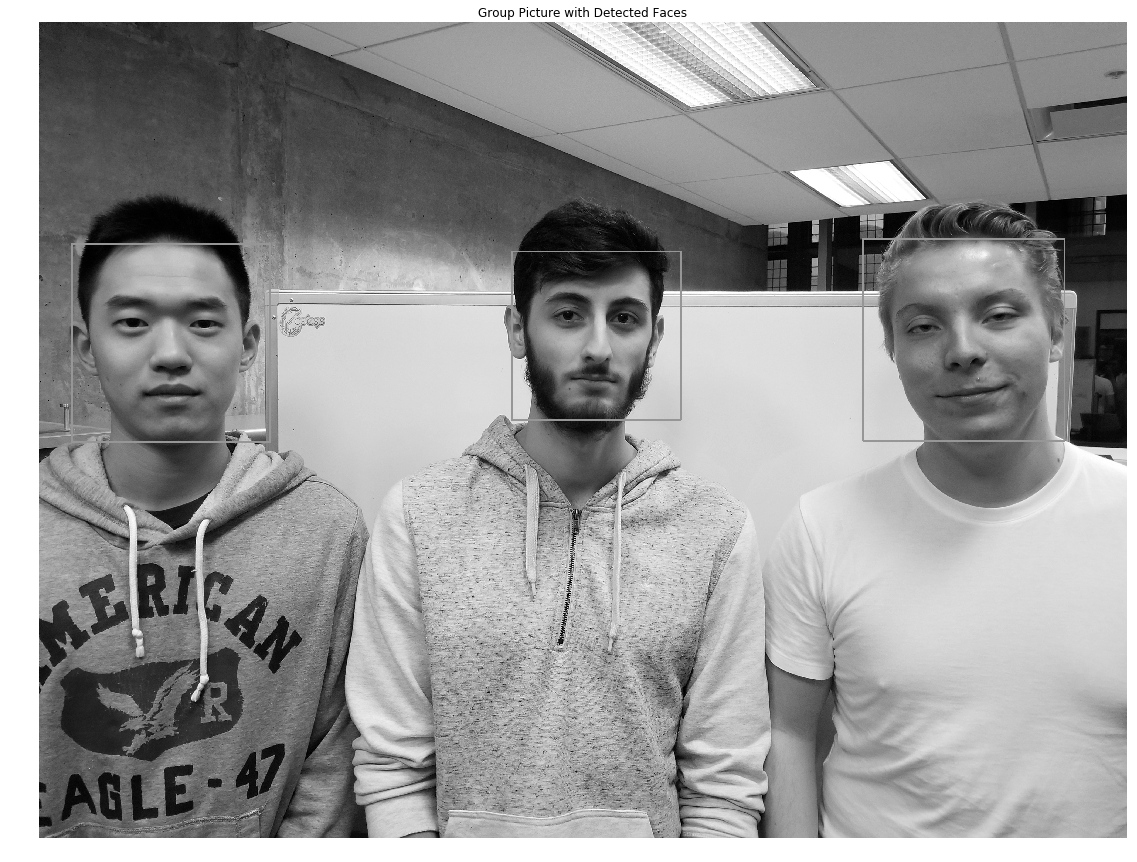

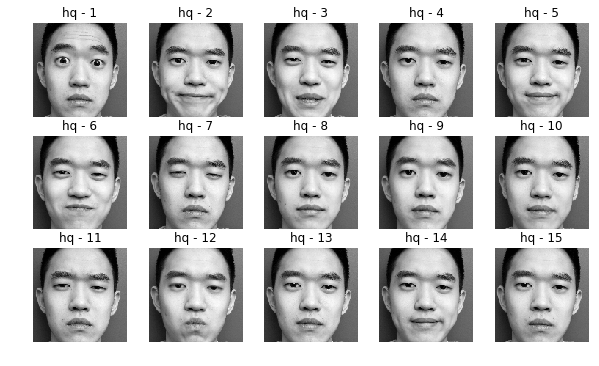

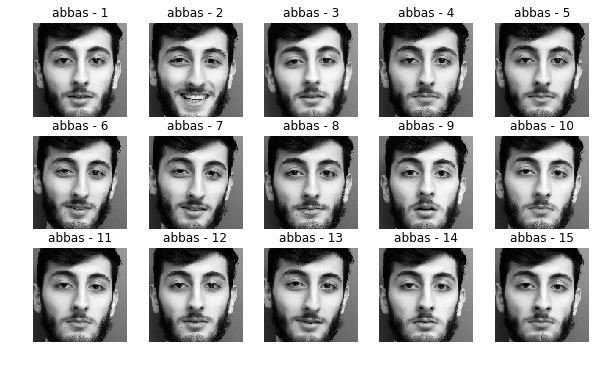

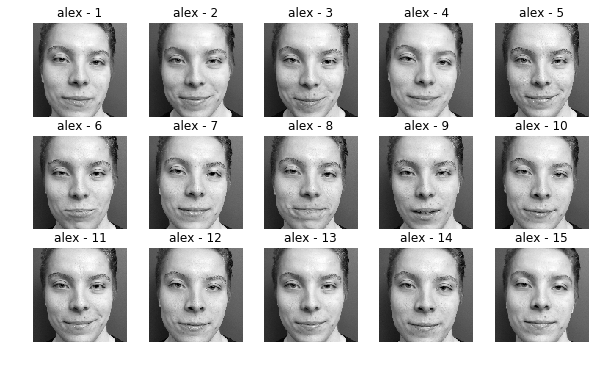

In [3]:
test_path = 'dataset/test/group.jpg'
train_path = 'dataset/train/'

# Detect all faces in group picture
face_cc = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_default.xml'))
group = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
group_faces = face_cc.detectMultiScale(group, 1.2, 10)

# Draw a box around each detected face
group_copy = group.copy()
for (x, y, w, h) in group_faces:
    cv2.rectangle(group_copy, (x, y), (x+w, y+h), (150,150,150), 5)

# Display test image
plt.figure(figsize=(30, 15))
plt.title('Group Picture with Detected Faces')
plt.imshow(group_copy, 'gray'), plt.axis('off')
plt.show()

# Read all training images
X, Y = [], []
train_sets = {}
size = (128, 128)
for img_set in os.listdir(train_path):
    images = []
    for img in os.listdir(os.path.join(train_path, img_set)):
        face = cv2.imread(os.path.join(train_path, img_set, img), cv2.IMREAD_GRAYSCALE)
        p = face_cc.detectMultiScale(face, 1.05, 15)
        if len(p):
            x, y, w, h = p[0]
            face = face[y:y+h, x:x+w]
        face = cv2.resize(face, size)
        images.append(face)
        X.append(face), Y.append(img_set)
    train_sets[img_set] = images

# Display training images
plotFigures(train_sets)

**Describe how you selected the images with respect to the conditions of the detection/classification methods.**

Seeing as we are doing both face detection and recognition, we tried taking pictures of all the faces so they could be similar. The pictures were taken in the same environment as to not influence the pictures with varying contrast or brightness or occlusions. We also tried to take the pictures using the same facial expression, angle and distance.

We used grayscale images since our facial detection and classification depends on features and not on colors. It also helps reduces computation time.

# 2. Eigenvector Representation

(45, 45)
[6.53983846e-01 1.20449374e-01 4.10101840e-02 3.24039188e-02
 1.80775114e-02 1.45394636e-02 1.27093836e-02 1.21109738e-02
 8.92901229e-03 7.59681642e-03 6.13916353e-03 5.12847928e-03
 4.97833240e-03 4.41775134e-03 4.19883648e-03 4.05082651e-03
 3.47668132e-03 3.37086249e-03 2.80171691e-03 2.74687675e-03
 2.45350974e-03 2.44143655e-03 2.28995147e-03 2.21635520e-03
 2.08494121e-03 1.98837577e-03 1.93580794e-03 1.85489246e-03
 1.83539877e-03 1.69687535e-03 1.67652415e-03 1.61518669e-03
 1.44986298e-03 1.29434010e-03 1.27330485e-03 1.25221557e-03
 1.20612886e-03 1.11167337e-03 1.01914016e-03 9.38354530e-04
 8.92482688e-04 8.61326602e-04 7.98512532e-04 6.93391358e-04
 1.77813871e-31]


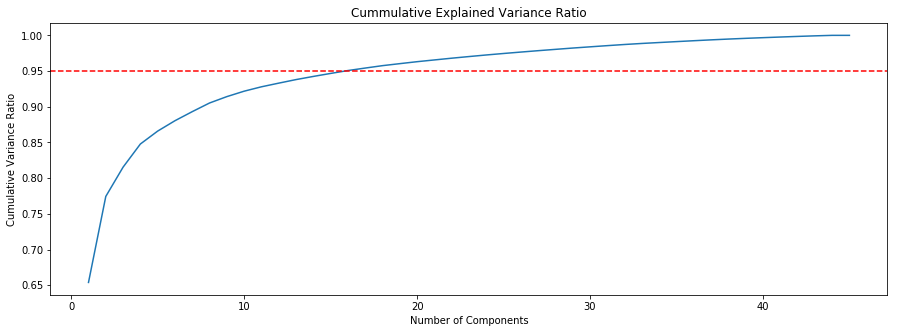

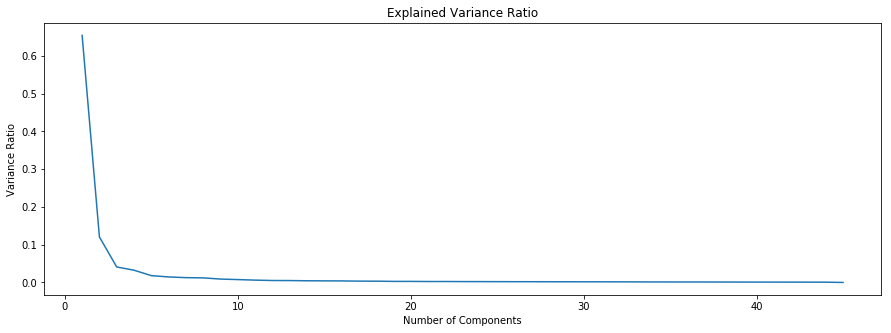

In [4]:
x, y = np.array(X), np.array(Y)
x = x.reshape(x.shape[0], -1)

# Create PCA and transform the test set
pca = PCA()
x_pca = pca.fit_transform(x)
evr_size = pca.explained_variance_ratio_.size

# Print the variance explained by every principal component
print(x_pca.shape)
print(pca.explained_variance_ratio_)

# Plot the cumulative summation of the explained variance
plt.figure(figsize=(15, 5))
plt.plot(range(1, evr_size+1), np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('Number of Components'), plt.ylabel('Cumulative Variance Ratio')
plt.title('Cummulative Explained Variance Ratio')
plt.show()

# Plot explained variance against the number of components
plt.figure(figsize=(15, 5))
plt.plot(range(1, evr_size+1), pca.explained_variance_ratio_)
plt.xlabel('Number of Components'), plt.ylabel('Variance Ratio')
plt.title('Explained Variance Ratio')
plt.show()

In [5]:
# Create PCA with 15 components and transform the test set
start = time.time()
pca15 = PCA(n_components=15)
pca15.fit_transform(x)
print('PCA using 15 components')
print(f'Variance Ratio: {sum(pca15.explained_variance_ratio_)}')
print(f'Computation time: {time.time()-start}\n')

# Create PCA with 45 components and transform the test set
pca45 = PCA(n_components=45)
pca45.fit_transform(x)
print('PCA using 45 components')
print(f'Variance Ratio: {sum(pca45.explained_variance_ratio_)}')
print(f'Computation time: {time.time()-start}')

PCA using 15 components
Variance Ratio: 0.9466649431904125
Computation time: 0.23837566375732422

PCA using 45 components
Variance Ratio: 1.0000000000000004
Computation time: 0.47083258628845215


**Do you need all the vectors to represent the data?**

No, we don't need to use all vectors. As we can see, the speed at which the explained variance ratio reduces becomes more negligeable after k=5. Once we hit k=15 components, the cumulative explained variance ratio is already beyong 95%. As a result, we can represent our training data with as little as 15 images, meaning we do not need to compute PCA for every component.

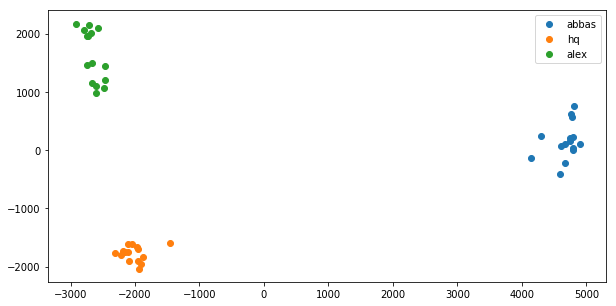

In [6]:
people = set(y)

plt.figure(figsize=(10, 5))
for mans in people:
    x_set = x_pca[y == mans, :]
    plt.scatter(x_set[:,0], x_set[:,1])
    plt.legend(people)

plt.show()

In [7]:
# Use K-nearest neighbors to evaluate clustering on eigenspace and original pixel space
start = time.time()
knc_e = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knc_e.fit(x_pca, y)
pred = knc_e.predict(x_pca)
print(f'Eigenspace accuracy: {accuracy_score(y, pred)}')
print(f'Computation time: {time.time()-start}\n')

start = time.time()
knc_p = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knc_p.fit(x, y)
pred = knc_p.predict(x)
print(f'Pixel space accuracy: {accuracy_score(y, pred)}')
print(f'Computation time: {time.time()-start}')

Eigenspace accuracy: 1.0
Computation time: 0.003043651580810547

Pixel space accuracy: 1.0
Computation time: 0.07651686668395996


**How well clustered is your data?**

There is no significant difference in between the accuracy of the eigenspace and pixel space. We can see from the cluster that all points from one class are near another point from the same class. The only main difference is the time taken for the computation, where it takes over 50 times the time in the pixel space.

# 3. Face Detection and Identification

In [8]:
def plotEigenfaces(images, size=6):
    """
    :param images: List of figures to plot
    :param size: Width size of the grid
    """

    plt.rcParams.update({'figure.max_open_warning': 0})
    plt.figure(figsize=(15, 15))
    for i, face in enumerate(images, 1):
        plt.subplot(size, size, i), plt.imshow(face, 'gray')
        plt.title(f'Eigenface {i}'), plt.axis('off')
    plt.show()

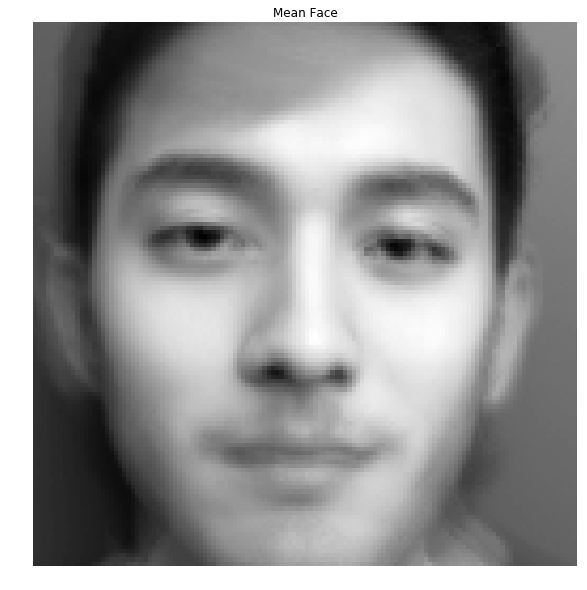

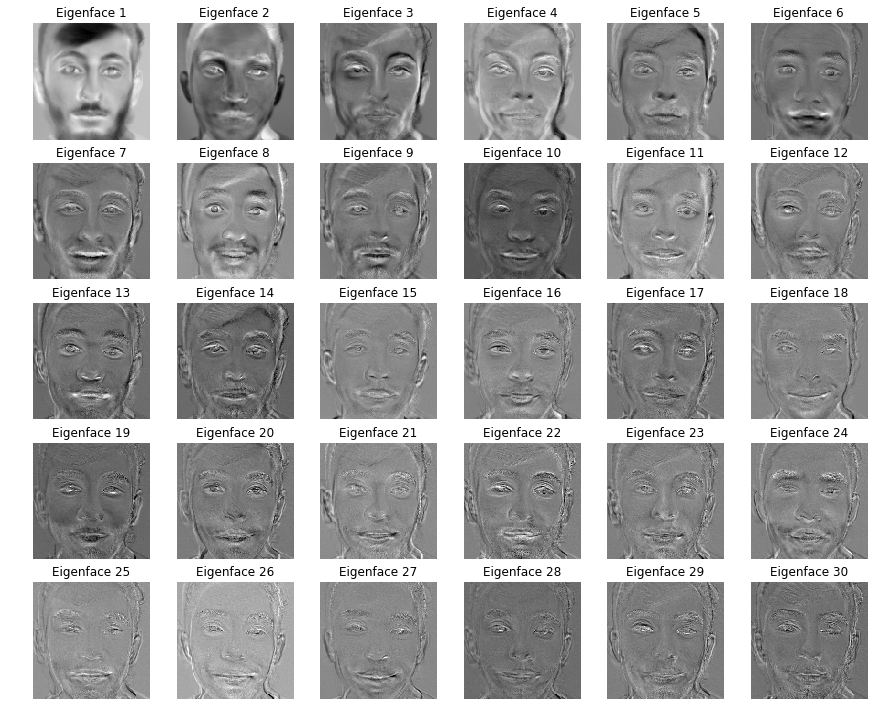

In [9]:
# Get mean face and eigenfaces
nc = 30
h, w = size
scales = [1, 1.05, 1.1]

# Create PCA using 30 components and transform the test set
pca = PCA(n_components=nc)
x_pca = pca.fit_transform(x)
mean_face = pca.mean_.reshape(h, w)
eigenfaces = pca.components_.reshape((nc, h, w))

# Display mean face
plt.figure(figsize=(10,10))
plt.imshow(mean_face, 'gray')
plt.title('Mean Face'), plt.axis('off')
plt.show()

plotEigenfaces(eigenfaces)

In [10]:
def slidingWindow(img, size, step=10):
    """
    :param img: Image to use slinding window on
    :param size: Size of the window to return
    :param step: Number of pixels to skip after each iteration
    :return: Generator with x, y coordinates and cropped image
    """

    for y in range(0, img.shape[0], step):
        for x in range(0, img.shape[1], step):
            img_crop = img[y:y+size[1], x:x+size[0]]
            yield (x, y, img_crop)

In [11]:
def reconstruct(centered, mean, eigenfaces):
    """
    :param centered: Image vector with zero mean
    :param mean: Mean face vector
    :param eigenfaces: Eigenvectors representing eigenfaces
    """
    
    reconstruction = mean
    for ev in eigenfaces:
        reconstruction += ev * np.dot(centered, ev)

    return reconstruction

In [13]:
# Flatten mean and eiganface vectors
mean_face_flat = mean_face.ravel()
eigenfaces_flat = eigenfaces.reshape(eigenfaces.shape[0], -1)

# Resize group image so faces can fit in the window size
test_img = cv2.resize(group.copy(), None, fx=0.2, fy=0.2)

norms = []
start = time.time()
# for scale in scales:
#     scaled_size = tuple(2*s for s in size)
for (xx, yy, img) in slidingWindow(test_img, size, 25):
    if img.shape != size:
        continue

    # Center image by subtracting mean and project onto eigenspace for reconstruction
    centered = img.ravel() - mean_face_flat
    reconstruction = reconstruct(centered, mean_face_flat, eigenfaces_flat)

    # Compute distance between original image and reconstruction
    norm = np.linalg.norm(centered - reconstruction)
    norms.append({'norm': norm, 'image': img, 'coordinates': (xx, yy)})

norm_vals = [n['norm'] for n in norms]
norm_min = min(norm_vals)
norm_std = np.std(np.array(norm_vals))
norm_mean = np.mean(np.array(norm_vals))
print('Min:', norm_min)
print('Std:', norm_std)
print('Mean:', norm_mean)
print('Computation time:', time.time() - start)

Min: 17426.4476674313
Std: 1309.640665546128
Mean: 19972.217911635773
Computation time: 4.706676483154297


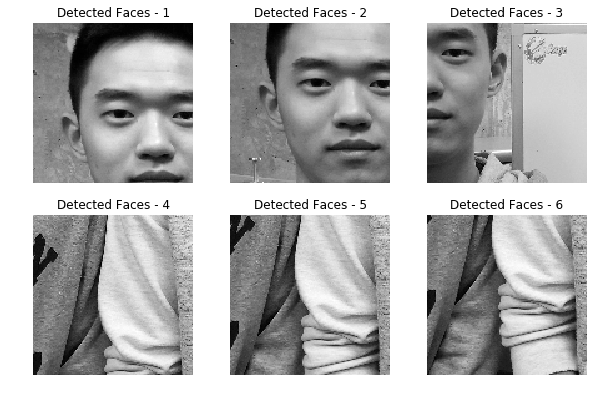

In [14]:
detected = []
test_img_copy = test_img.copy()

# If the distance is smaller than the threshold, it's considered a face
weight = 1.69
thresh = norm_mean - norm_std * weight
for val in norms:
    norm = val['norm']
    img = val['image']
    xx, yy = val['coordinates']

    if norm < thresh:
        cv2.rectangle(test_img_copy, (xx,yy), (xx+size[0],yy+size[1]), (255,255,255), 5)
        detected.append(img)

plotFigures(detected, size=3, title='Detected Faces')

In [15]:
print('Prediction for Eigenface faces.')
for i, face in enumerate(detected, 1):
    print(f'Face {i} recognized as:', knc_p.predict([face.reshape(face.shape[0]**2)]))

Prediction for Eigenface faces.
Face 1 recognized as: ['abbas']
Face 2 recognized as: ['alex']
Face 3 recognized as: ['alex']
Face 4 recognized as: ['alex']
Face 5 recognized as: ['alex']
Face 6 recognized as: ['alex']


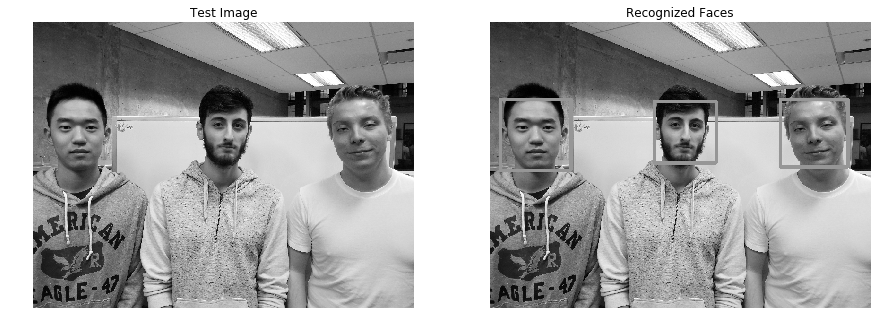

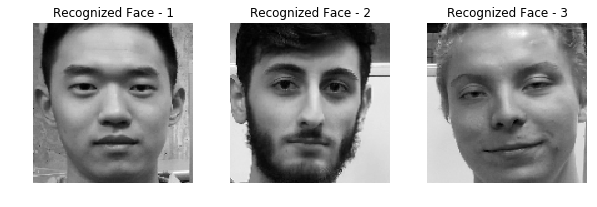

In [16]:
# Detect all faces in group picture
test_faces = face_cc.detectMultiScale(test_img, 1.2, 10)

# Get faces for facial recognition
detected_faces = test_img.copy()
recognized = []

for (xx, yy, ww, hh) in test_faces:
    cv2.rectangle(detected_faces, (xx,yy), (xx+ww,yy+hh), (150,150,150), 5)
    recognized.append(cv2.resize(test_img[yy:yy+hh, xx:xx+ww], size))
    
plt.figure(figsize=(15,15))
plt.subplot(121), plt.title('Test Image')
plt.imshow(test_img, 'gray'), plt.axis('off')
plt.subplot(122), plt.title('Recognized Faces')
plt.imshow(detected_faces, 'gray'), plt.axis('off')
plt.show()

plotFigures(recognized, size='3', title='Recognized Face')

In [17]:
print(f'Prediction for Haar Cascade detection.')
for i, face in enumerate(recognized, 1):
    print(f'Face {i} recognized as:', knc_p.predict([face.reshape(face.shape[0]**2)]))

Prediction for Haar Cascade detection.
Face 1 recognized as: ['hq']
Face 2 recognized as: ['abbas']
Face 3 recognized as: ['alex']


**How well does the method work? How many false positive face detections do you get? In which situations would expect the approach to fail, and what could you do to improve it?**

It is obvious that the running facial recognition using the faces detected using Haar Cascades give 100% accuracy, whereas those from my face detection are all wrong. The reason can mostly be given to the fact that I was not able to correctly detect the faces and crop them properly which would improve the result of the facial recognition.

It was possible to reduce the number of false positives by tweaking the parameters used in the face detection, although to a certain extent. As can be seen, it would always detect my arm as a face, no matter how I tuned the parameters. This was one of the bigger flaws, and also affected the results of the facial recognition. I tried reducing the margin of error by computing multiple window sizes during the sliding window reconstruction, although I was not able to.

Using eigenfaces for facial recognition is a strong approach in situations where images are all aligned properly. As previously mentionned, the issue is that all images need to look very similar as to not introduce noise and have an accurate mean. At the same time, having a lot more than 15 train images helps when reconstructing the images.

# 4. Viola-Jones Comparison

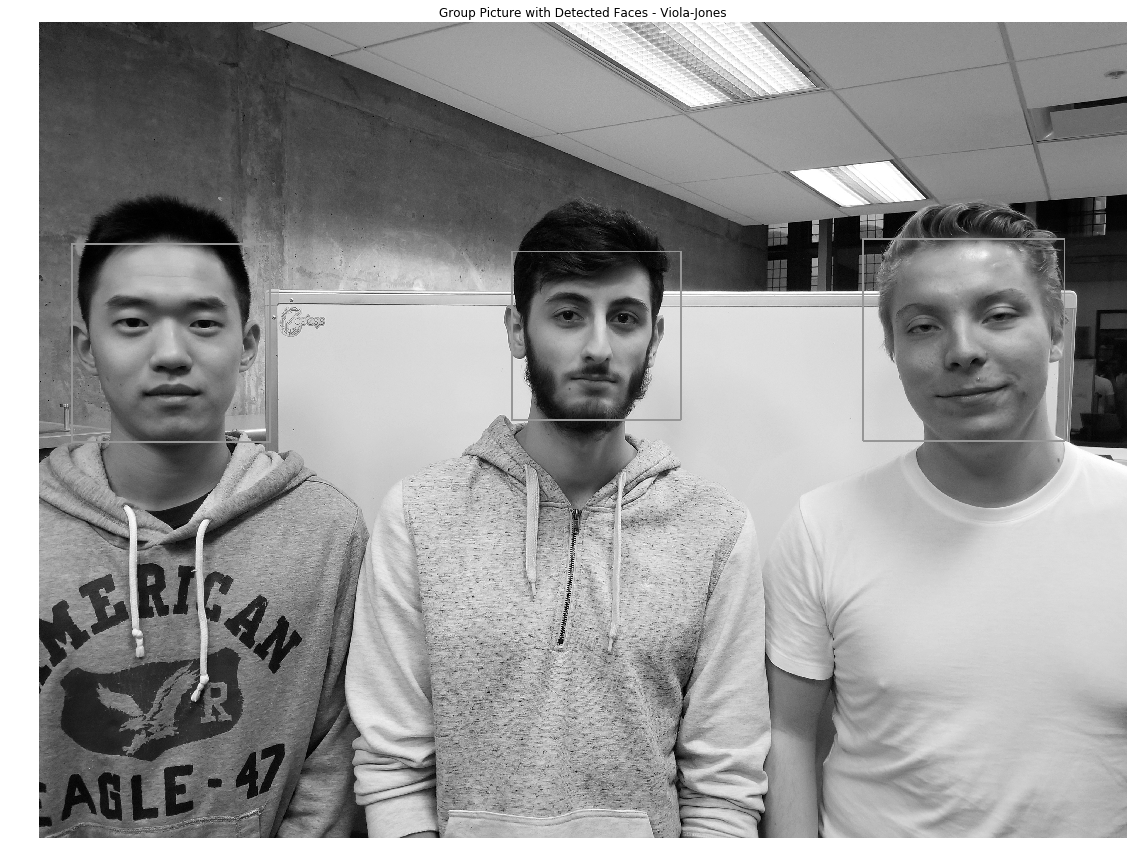

In [18]:
test_path = 'dataset/test/group.jpg'

# Detect all faces in group picture using Viola-Jones Detector (Haar Cascade)
face_cc = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_default.xml'))
group = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
group_faces = face_cc.detectMultiScale(group, 1.2, 10)

# Draw a box around each detected face
group_copy = group.copy()
for (x, y, w, h) in group_faces:
    cv2.rectangle(group_copy, (x, y), (x+w, y+h), (150,150,150), 5)

# Display image with detected faces
plt.figure(figsize=(30, 15))
plt.title('Group Picture with Detected Faces - Viola-Jones')
plt.imshow(group_copy, 'gray'), plt.axis('off')
plt.show()

**Under what conditions would you expect the Viola-Jones detector to work when PCA does not?**

The problem with PCA is that in a group picture, the faces will never be at the same range, meaning they will all be scaled differently. Viola-Jones fixes this issue by being agnostic to the sizes of the faces which makes it a better detector for face detection where there are many faces and many occlusions.